<a href="https://colab.research.google.com/github/marinba2200/DL_test/blob/main/1223_4_LSTM_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import library and create data

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:

$$ x(t) = \sin(\omega t^2) $$

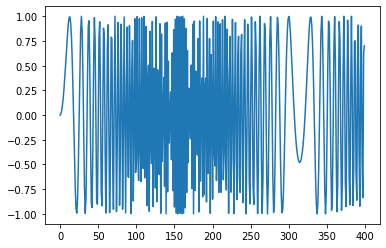

In [ ]:
# plot it
plt.plot(series)
plt.show()

### Build the dataset

In [ ]:
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


### First, try autoregressive linear model

In [ ]:
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.01))

# train the model
r = model.fit(X[:N//2], Y[:N//2], epochs=80, validation_data=(X[N//2:], Y[N//2:]))

Epoch 1/80
7/7 [==============================] - 2s 52ms/step - loss: 1.8625 - val_loss: 1.2043
Epoch 2/80
7/7 [==============================] - 0s 6ms/step - loss: 1.5860 - val_loss: 1.1127
Epoch 3/80
7/7 [==============================] - 0s 6ms/step - loss: 1.2627 - val_loss: 1.0297
Epoch 4/80
7/7 [==============================] - 0s 6ms/step - loss: 1.2435 - val_loss: 0.9626
Epoch 5/80
7/7 [==============================] - 0s 6ms/step - loss: 1.1142 - val_loss: 0.9013
Epoch 6/80
7/7 [==============================] - 0s 6ms/step - loss: 0.8985 - val_loss: 0.8278
Epoch 7/80
7/7 [==============================] - 0s 6ms/step - loss: 0.7654 - val_loss: 0.7704
Epoch 8/80
7/7 [==============================] - 0s 6ms/step - loss: 0.7968 - val_loss: 0.7431
Epoch 9/80
7/7 [==============================] - 0s 7ms/step - loss: 0.6476 - val_loss: 0.7213
Epoch 10/80
7/7 [==============================] - 0s 6ms/step - loss: 0.5989 - val_loss: 0.7032
Epoch 11/80
7/7 [=====================

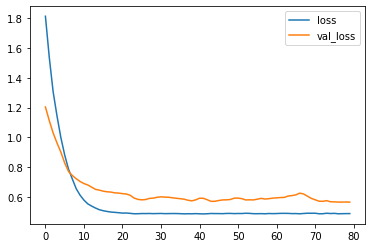

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

#### Predictions

(390, 1)


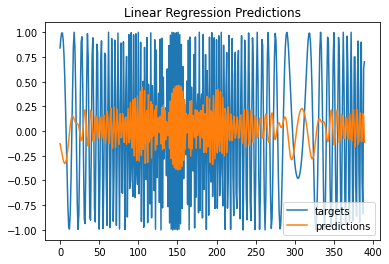

In [ ]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
predictions = model.predict(X)
print(predictions.shape)

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

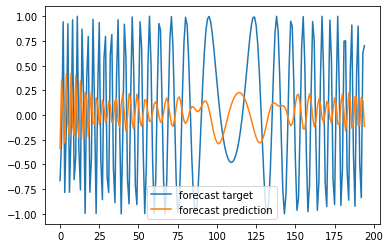

In [ ]:
# This is the code we had before - it does the same thing

# One-step forecast using true targets

validation_target = Y[N//2:]
validation_predictions = []

# index of first validation input
i = N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))#[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

validation_predictions = np.reshape(validation_predictions, (-1, 1))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

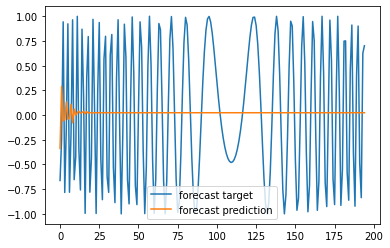

In [ ]:
# Multi-step forecast
validation_target = Y[N//2:]
validation_predictions = []

# first validation input
last_x = X[N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))#[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

validation_predictions = np.reshape(validation_predictions, (-1, 1))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Second, try RNN model

In [ ]:
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = SimpleRNN(10)(i) #十個神經元
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.05))
model.summary() # ((10+1)+1)*10=120

# train the RNN
r = model.fit(X[:N//2], Y[:N//2], batch_size=32, epochs=200, validation_data=(X[N//2:], Y[N//2:]))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
7/7 [==============================] - 1s 37ms/step - loss: 0.6856 - val_loss: 0.5016
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 0.5356 - val_loss: 0.4796
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5636 - val_loss: 0.5710
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 0.5012 - val_loss: 0.5335

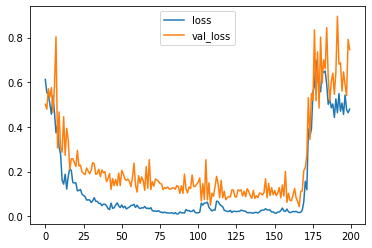

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)


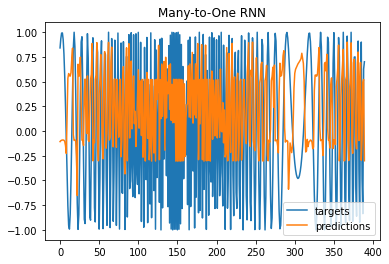

In [ ]:
# One-step forecast using true targets
predictions = model.predict(X)
print(predictions.shape)

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Many-to-One RNN")
plt.legend()
plt.show()

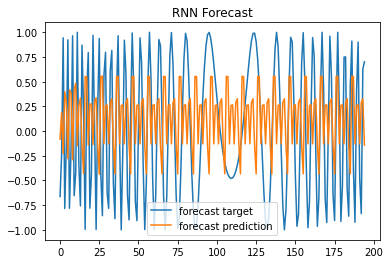

In [ ]:
# Multi-step forecast
validation_target = Y[N//2:]
validation_predictions = []

last_x = X[N//2]

while len(validation_predictions) < len(validation_target):
  # Reshape the input_ to N x T x D
  p = model.predict(last_x.reshape(1, T, 1))#[0,0]
  validation_predictions.append(p)

  # make a new input with the latest forecast
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

validation_predictions = np.reshape(validation_predictions, (-1, 1))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.title("RNN Forecast")
plt.legend()
plt.show()

### Third, try LSTM model

In [ ]:
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i) #30
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.05))
model.summary() # ((10+1)+1)*4*10=480  #((30+1)+1)*4*30=3840

# train the RNN
r = model.fit(X[:N//2], Y[:N//2], batch_size=32, epochs=200, validation_data=(X[N//2:], Y[N//2:]))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
7/7 [==============================] - 6s 58ms/step - loss: 0.4981 - val_loss: 0.6208
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 0.4890 - val_loss: 0.5302
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.3976 - val_loss: 0.5830
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.3091 - val_loss: 0.4470
Ep

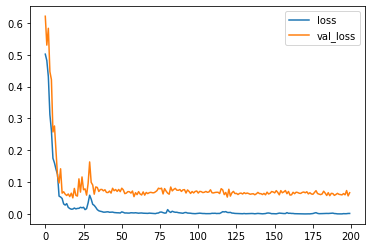

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)


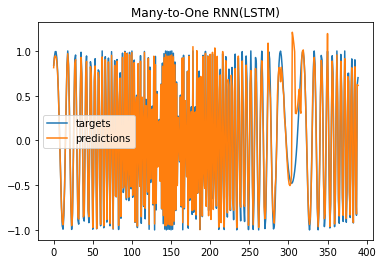

In [ ]:
# One-step forecast using true targets
predictions = model.predict(X)
print(predictions.shape)

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Many-to-One RNN(LSTM)")
plt.legend()
plt.show()

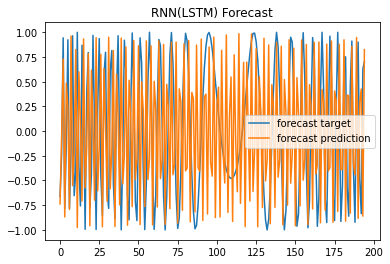

In [ ]:
# Multi-step forecast
validation_target = Y[N//2:]
validation_predictions = []

last_x = X[N//2]

while len(validation_predictions) < len(validation_target):
  # Reshape the input_ to N x T x D
  p = model.predict(last_x.reshape(1, T, 1))#[0,0]
  validation_predictions.append(p)

  # make a new input with the latest forecast
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

validation_predictions = np.reshape(validation_predictions, (-1, 1))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.title("RNN(LSTM) Forecast")
plt.legend()
plt.show()

Because this dataset doesn't really have any long term dependencies, at least for the time